# Dataset: COMPAS recidivism and COMPAS violent recidivism

In [1]:
import os
import pandas as pd
import numpy
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OrdinalEncoder
%matplotlib inline
import matplotlib.ticker as mtick

In [2]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy
import pygraphviz

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)
from sklearn.model_selection import train_test_split

In [3]:
#References:
# https://benhay.es/posts/predicting-criminal-recidivism-r/
# http://www.cs.toronto.edu/~guerzhoy/201s20/proj/proj1/soln.html
# https://rstudio-pubs-static.s3.amazonaws.com/462775_4c23ffebf7794a4e903d4de1571a44a9.html

# 1. Recidivism Data Analysis

In [20]:
#Load clean data
df=pd.read_csv('compas-scores-two-years_clean.csv')
#Load full data
#df=pd.read_csv('compas-scores-two-years.csv')

In [21]:
len(df.keys())

53

In [22]:
len(df)

6172

In [23]:
categorical_columns = (df
    .select_dtypes(['category', 'object'])
    #.drop("two_year_recid", axis=1)
    .columns)

In [24]:
categorical_columns

Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age_cat', 'race', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc',
       'r_case_number', 'r_charge_degree', 'r_offense_date', 'r_charge_desc',
       'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody'],
      dtype='object')

In [25]:
len(categorical_columns)

33

In [26]:
numeric_columns = (df
    .select_dtypes(['number'])    
    .columns)

In [27]:
numeric_columns

Index(['id', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_days_from_compas', 'is_recid', 'r_days_from_arrest', 'violent_recid',
       'is_violent_recid', 'decile_score.1', 'v_decile_score',
       'priors_count.1', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [28]:
df['race'].value_counts()/len(df)

African-American    0.514420
Caucasian           0.340732
Hispanic            0.082469
Other               0.055574
Asian               0.005023
Native American     0.001782
Name: race, dtype: float64

In [29]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [30]:
df['two_year_recid'].value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

In [31]:
#Class imbalance
len(df.loc[df['two_year_recid']==1])/len(df.loc[df['two_year_recid']==0])

0.8352661314302706

In [32]:
df['sex'].value_counts()/len(df)

Male      0.809624
Female    0.190376
Name: sex, dtype: float64

In [50]:
df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [56]:
ratio_sex_recid = pd.crosstab(df['two_year_recid'], df['sex']).div(pd.crosstab(df['two_year_recid'], df['sex']).apply(sum,0),1)

In [57]:
ratio_sex_recid

sex,Female,Male
two_year_recid,,
0,0.648511,0.520512
1,0.351489,0.479488


### statistical parity difference

In [16]:
def statistical_parity_difference(dataset, protected,classes,majority_group, minority_group,value):
    ratio = round(pd.crosstab(dataset[protected], dataset[classes]).div(pd.crosstab(dataset[protected], dataset[classes]).apply(sum,1),0),4)*100
    return ratio
    #return ratio.loc[majority_group][value]-income_gender_percent.loc[minority_group][value]

In [17]:
statistical_parity_difference(df,'race','two_year_recid','Caucasian','African-American','0')

two_year_recid,0,1
race,,
African-American,48.57,51.43
Asian,71.88,28.12
Caucasian,60.64,39.36
Hispanic,63.58,36.42
Native American,44.44,55.56
Other,64.72,35.28


In [18]:
df['two_year_recid'].value_counts()

0    3963
1    3251
Name: two_year_recid, dtype: int64

In [19]:
df['c_charge_degree'].value_counts()

F    4666
M    2548
Name: c_charge_degree, dtype: int64

In [20]:
def basic_info(dataset,class_label,positive_value,negative_value,protected_attr,majority_group,minority_group):
    categorical_columns = (dataset.select_dtypes(['category', 'object']).columns)
    numeric_columns = (dataset.select_dtypes(['number']).columns)
    for attr in dataset.keys():
        if attr in categorical_columns:    
            print(attr ,' & Categorical & ',len(dataset[attr].value_counts()),'& &',dataset[attr].isnull().sum(),'\\\\')
        else:           
            print(attr,'& Numerical &',len(dataset[attr].value_counts()),'&',dataset[attr].min(),"-",dataset[attr].max(),'&',dataset[attr].isnull().sum(),'\\\\')  
    
    print('Class distribution:',dataset[class_label].value_counts())
    print('Class imbalance:',len(dataset.loc[dataset[class_label]==positive_value]),":",len(dataset.loc[dataset[class_label]==negative_value]))
    print('statistical parity:',statistical_parity_difference(dataset,protected_attr,class_label,majority_group,minority_group,positive_value))

In [21]:
basic_info(df,class_label="two_year_recid",positive_value=1,negative_value=0,
           protected_attr="race",majority_group='African-American',minority_group='Caucasian')

id & Numerical & 7214 & 1 - 11001 & 0 \\
name  & Categorical &  7158 & & 0 \\
first  & Categorical &  2800 & & 0 \\
last  & Categorical &  3950 & & 0 \\
compas_screening_date  & Categorical &  690 & & 0 \\
sex  & Categorical &  2 & & 0 \\
dob  & Categorical &  5452 & & 0 \\
age & Numerical & 65 & 18 - 96 & 0 \\
age_cat  & Categorical &  3 & & 0 \\
race  & Categorical &  6 & & 0 \\
juv_fel_count & Numerical & 11 & 0 - 20 & 0 \\
decile_score & Numerical & 10 & 1 - 10 & 0 \\
juv_misd_count & Numerical & 10 & 0 - 13 & 0 \\
juv_other_count & Numerical & 10 & 0 - 17 & 0 \\
priors_count & Numerical & 37 & 0 - 38 & 0 \\
days_b_screening_arrest & Numerical & 423 & -414.0 - 1057.0 & 307 \\
c_jail_in  & Categorical &  6907 & & 307 \\
c_jail_out  & Categorical &  6880 & & 307 \\
c_case_number  & Categorical &  7192 & & 22 \\
c_offense_date  & Categorical &  927 & & 1159 \\
c_arrest_date  & Categorical &  580 & & 6077 \\
c_days_from_compas & Numerical & 499 & 0.0 - 9485.0 & 22 \\
c_charge_degree  &

In [20]:
#Missing values
print('Missing values')
for i,j in zip(df.columns,(df.values.astype(str) == 'N/A').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' records')
print("---------------------------------")
df.isnull().sum()

Missing values
---------------------------------


id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest       0
c_jail_in                     0
c_jail_out                    0
c_case_number                 0
c_offense_date              784
c_arrest_date              5388
c_days_from_compas            0
c_charge_degree               0
c_charge_desc                 5
is_recid                      0
r_case_number              3182
r_charge_degree            3182
r_days_from_arrest         4175
r_offense_date             3182
r_charge_desc              3228
r_jail_in                  4175
r_jail_o

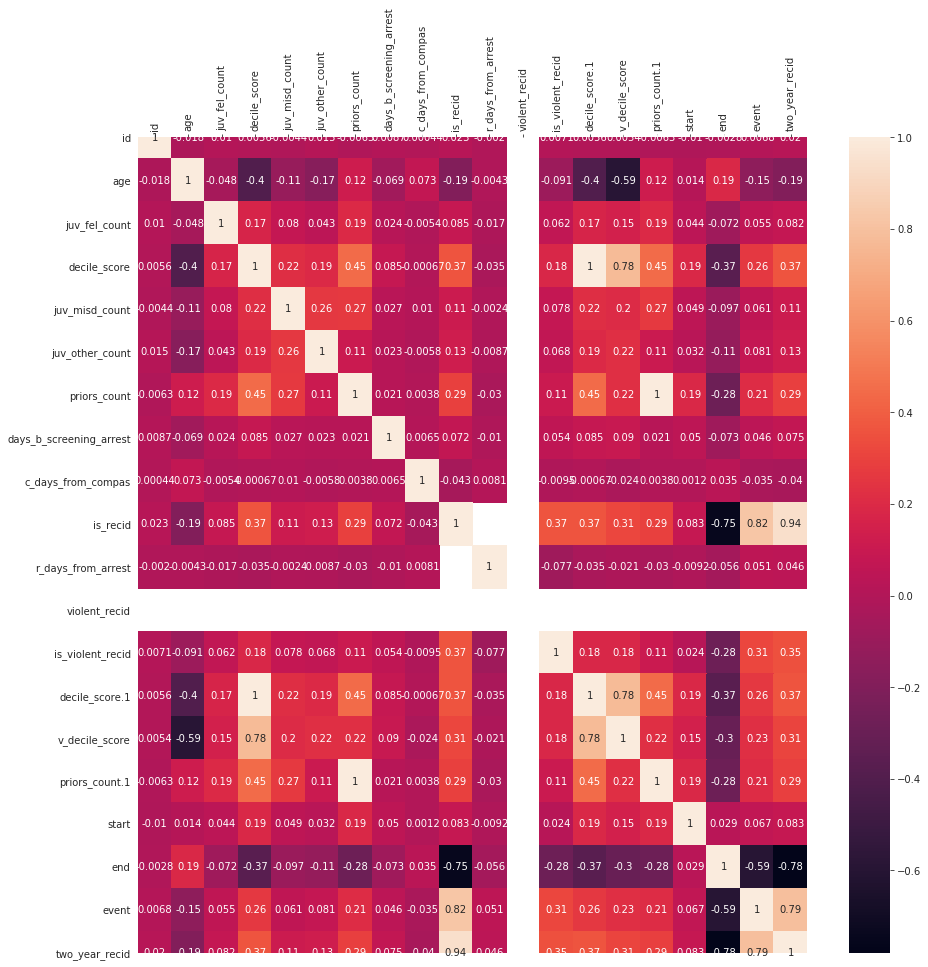

In [21]:
corr = df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True
    
);
ax.xaxis.set_ticks_position('top') 
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.show()

In [44]:
def plot_2_variable(dataset,var1, var2, width, wide,height,legend, title):
    
    var1_var2_ratio=round(pd.crosstab(dataset[var1], dataset[var2]).div(pd.crosstab(dataset[var1], dataset[var2]).apply(sum,1),0),3)*100
    var1_var2 =  pd.crosstab(dataset[var1], dataset[var2])
    ax = var1_var2.plot(kind='bar',width=width,figsize=(wide,height)
                     #,logy=True
                     )
    #x = hour_income_gender.plot(kind ='bar',stacked=False)
    xlocs, xlabs = plt.xticks()
    for i in range(len(var1_var2)):
        for j in range(len(var1_var2.iloc[i])):
            plt.text(xlocs[i]-0.35+j*0.35, var1_var2.iloc[i][j] + 2,str(round(var1_var2_ratio.iloc[i][j],1))+"%" )
    #plt.title('Distribution of '+ title+ ' across '+ legend)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.ylabel('Number of defendants',fontsize=14,fontweight='bold')
    plt.xlabel(title,fontsize=14,fontweight='bold')
    plt.rc('xtick',labelsize=11)
    plt.rc('ytick',labelsize=11)
    plt.xticks(rotation=0)
    plt.legend(title=legend)
    filename=var1+"_"+var2+".pdf"
    plt.savefig(filename)

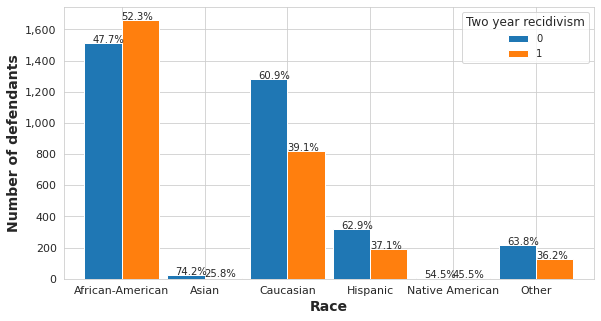

In [54]:
#Plot two_year_recidivism and race
plot_2_variable(df,'race','two_year_recid', 0.9,9.5,5,'Two year recidivism','Race')

###  Priors count and two-year-recid

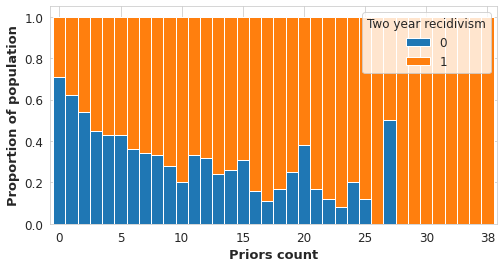

In [57]:
#Priors count and two-year-recid
prior_two_year = round(pd.crosstab(df['priors_count'], df['two_year_recid']).div(pd.crosstab(df['priors_count'], df['two_year_recid']).apply(sum,1),0),2)
ax = prior_two_year.plot(kind ='bar', stacked=True,figsize = (8,4),color=['tab:blue','tab:orange'],width=1.0)
ax.set_xlabel('Priors count',fontsize=13,fontweight='bold')
ax.set_ylabel('Proportion of population',fontsize=13,fontweight='bold')

my_pos=[i*5 for i in range(8)]
my_xticks = [i*5 for i in range(7)]
#my_pos.append(36)
my_xticks.append(38)

plt.xticks(my_pos, my_xticks,rotation=0)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Two year recidivism',loc='upper right',fontsize=12)
plt.savefig("prior_two_year_recid.pdf",bbox_inches='tight')

### Violinplot - Age - Score text - Race - Two year recid

In [31]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [32]:
new_df = df[(df['race']=='African-American') | (df['race'] == "Caucasian")]

In [61]:
pd.crosstab(new_df['race'],new_df['two_year_recid'])/len(new_df)


two_year_recid,0,1
race,,
African-American,0.286851,0.314703
Caucasian,0.242706,0.155741


In [60]:
new_df['race'].value_counts()

African-American    3175
Caucasian           2103
Name: race, dtype: int64

0
1


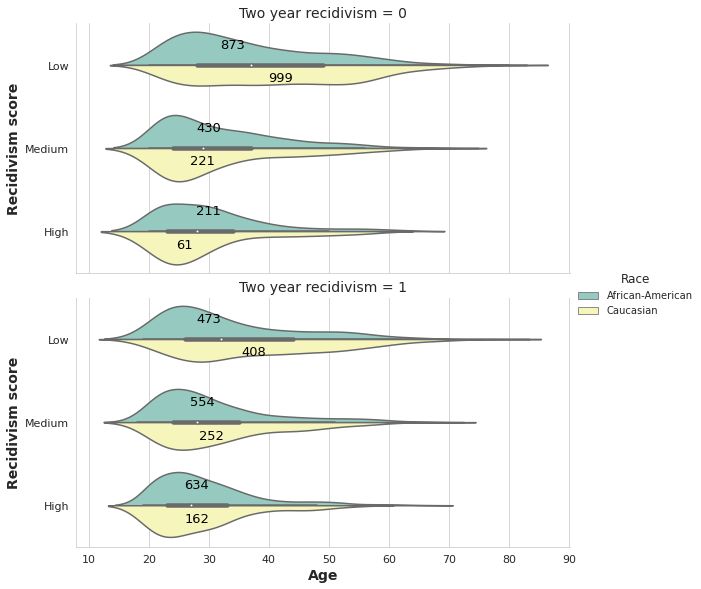

In [55]:
sns.set_style("whitegrid")
fig=sns.catplot(x="age", y="score_text", hue="race", row ="two_year_recid",kind="violin", data=new_df, orient="h", 
            height=4, aspect=2, palette="Set3",split=True,grid=True)
fig.set_xlabels('Age', fontsize=14,fontweight='bold')
fig.set_ylabels('Recidivism score', fontsize=14,fontweight='bold')
fig._legend.set_title('Race')
plt.rcParams['legend.title_fontsize'] = '12' 
medians = new_df.groupby(['two_year_recid','score_text','race'])['age'].median()
#medians = medians.fillna(50)
nobs =  new_df.groupby(['two_year_recid','score_text','race']).apply(lambda x: '{}'.format(len(x)))

for ax in plt.gcf().axes:
    ax_two_year_recid = ax.get_title().partition(' = ')[-1]    
    print(ax_two_year_recid)
    
    for tick, label in enumerate(ax.get_yticklabels()):
        ax_score_text = label.get_text()        

        for j, ax_race in enumerate(ax.get_legend_handles_labels()[1]):
            x_offset = (j - 0.5) * 2/5            
            med_val = medians[int(ax_two_year_recid), ax_score_text, ax_race]
            try:
                num = nobs[int(ax_two_year_recid), ax_score_text, ax_race]           
            except:
                num = 0
                
            ax.text(med_val + 1,tick + x_offset , num,
                    horizontalalignment='center', size='13', color='black', weight='normal')

axes = fig.axes.flatten()
axes[0].set_title("Two year recidivism = 0",size=14)
axes[1].set_title("Two year recidivism = 1",size=14)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

plt.savefig('compas_violin.pdf', bbox_inches='tight')

# 2. Violent Recidivism Data Analysis

In [34]:
#Load cleaned data
df1=pd.read_csv('compas-scores-two-years-violent_clean.csv')
#load full data
#df1=pd.read_csv('compas-scores-two-years-violent.csv')

In [35]:
df1['two_year_recid'].value_counts()

0    3368
1     652
Name: two_year_recid, dtype: int64

In [36]:
basic_info(df1,class_label="two_year_recid",positive_value=1,negative_value=0,
           protected_attr="race",majority_group='African-American',minority_group='Caucasian')

NameError: name 'basic_info' is not defined

In [37]:
len(df1)

4020

In [75]:
df1['race'].value_counts()/len(df1)

African-American    0.477114
Caucasian           0.362935
Hispanic            0.088308
Other               0.063433
Asian               0.006468
Native American     0.001741
Name: race, dtype: float64

In [38]:
df1['sex'].value_counts()/len(df1)

Male      0.790796
Female    0.209204
Name: sex, dtype: float64

In [39]:
df1['sex'].value_counts()

Male      3179
Female     841
Name: sex, dtype: int64

In [58]:
ratio_sex_viol_recid = pd.crosstab(df1['two_year_recid'], df1['sex']).div(pd.crosstab(df1['two_year_recid'], df1['sex']).apply(sum,0),1)

In [59]:
ratio_sex_viol_recid

sex,Female,Male
two_year_recid,,
0,0.908442,0.819126
1,0.091558,0.180874


In [41]:
#Class imbalance
len(df1.loc[df1['two_year_recid']==1])/len(df1.loc[df1['two_year_recid']==0])

0.19358669833729217

In [42]:
statistical_parity_difference(df1,'race','two_year_recid','Caucasian','African-American','0')

two_year_recid,0,1
race,,
African-American,78.94,21.06
Asian,88.46,11.54
Caucasian,88.07,11.93
Hispanic,90.14,9.86
Native American,85.71,14.29
Other,86.27,13.73


In [71]:
new_df1 = df1[(df1['race']=='African-American') | (df1['race'] == "Caucasian")]

In [72]:
pd.crosstab(new_df1['race'],new_df1['two_year_recid'])/len(new_df1)

two_year_recid,0,1
race,,
African-American,0.448327,0.119633
Caucasian,0.380515,0.051525


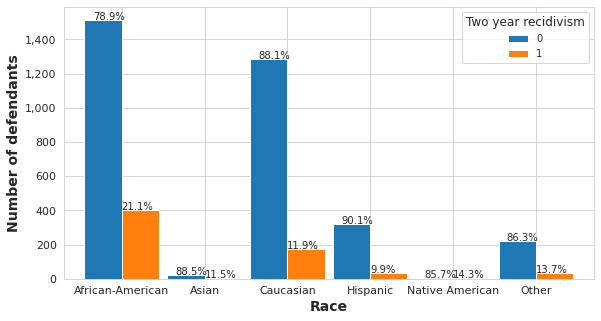

In [53]:
#Plot two_year_recidivism and race
plot_2_variable(df1,'race','two_year_recid', 0.9,9.5,5,'Two year recidivism','Race')

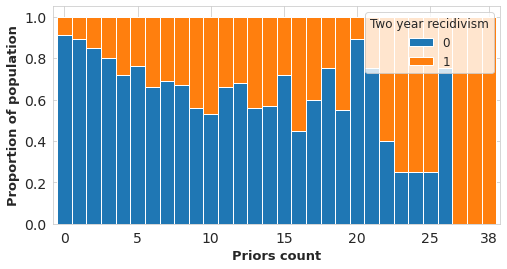

In [56]:
#Priors count and two-year-recid
prior_two_year = round(pd.crosstab(df1['priors_count'], df1['two_year_recid']).div(pd.crosstab(df1['priors_count'], df1['two_year_recid']).apply(sum,1),0),2)
ax = prior_two_year.plot(kind ='bar', stacked=True,figsize = (8,4),color=['tab:blue','tab:orange'],width=1.0)
ax.set_xlabel('Priors count',fontsize=13,fontweight='bold')
ax.set_ylabel('Proportion of population',fontsize=13,fontweight='bold')

my_pos=[i*5 for i in range(6)]
my_xticks = [i*5 for i in range(6)]
my_pos.append(29)
my_xticks.append(38)

plt.xticks(my_pos, my_xticks,rotation=0)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Two year recidivism',loc='upper right',fontsize=12)
plt.savefig("prior_two_year_recid_vio.pdf",bbox_inches='tight')

# 3. BN chart

## 3.1 COMPAS recid.

In [38]:
df_bn=df.drop(columns=['id','name', 'first', 'last', 'compas_screening_date','dob','age','days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'is_recid', 'r_case_number','c_charge_desc','r_charge_desc',
       'r_days_from_arrest', 'r_offense_date',
        'r_jail_in', 'r_jail_out', 'violent_recid','r_charge_degree',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment','v_type_of_assessment','v_screening_date', 
                     'in_custody', 'out_custody','start', 'end', 'screening_date','event','v_decile_score','decile_score.1','priors_count.1','decile_score'])

In [39]:
jsum=df_bn['juv_fel_count']+df_bn['juv_misd_count']+df_bn['juv_other_count']
df_bn['juv_fel_count']=jsum
df_bn=df_bn.rename(columns={'juv_fel_count':'juv_crime'})
df_bn=df_bn.drop(columns=['juv_misd_count','juv_other_count'])

In [40]:
X=df_bn.values

In [41]:
set(X[:,2])

{'African-American',
 'Asian',
 'Caucasian',
 'Hispanic',
 'Native American',
 'Other'}

In [42]:
for i in range(len(list(df_bn.keys()))):
    print(i,list(df_bn.keys())[i])

0 sex
1 age_cat
2 race
3 juv_crime
4 priors_count
5 c_charge_degree
6 score_text
7 v_score_text
8 two_year_recid


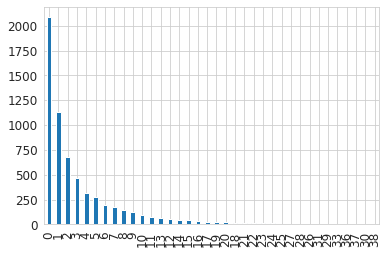

In [43]:
df_bn['priors_count'].value_counts().plot(kind='bar')

In [44]:
#X[:,5]=numpy.array([0 if v<1 else 1 if v>=1 and v<=5 else 2 for v in X[:,5]])
X[:,4]=numpy.array([0 if v==0 else 1 if v>0 and v<=5 else 2 for v in X[:,4]]) #priors_count
X[:,3]=numpy.array([0 if v==0 else 1 for v in X[:,3]]) #juv_crime
#X[:,2]=numpy.array(['Minority' if v!='Caucasian' else v for v in X[:,2]])

In [45]:
labels=list(df_bn.keys())
#labels[5]='Current_charge_degree'
#labels[6]='score'
#labels[7]='violence_score'
labels

['sex',
 'age_cat',
 'race',
 'juv_crime',
 'priors_count',
 'c_charge_degree',
 'score_text',
 'v_score_text',
 'two_year_recid']

In [46]:
model = BayesianNetwork.from_samples(X, algorithm='exact',state_names=labels)#BayesianNetwork.from_samples(X, algorithm='chow-liu')#BayesianNetwork.from_samples(X, algorithm='exact-dp')#

print(model.structure)

((4, 7), (3, 4), (6,), (4,), (), (4, 6), (1, 4), (1, 6), (4, 6))


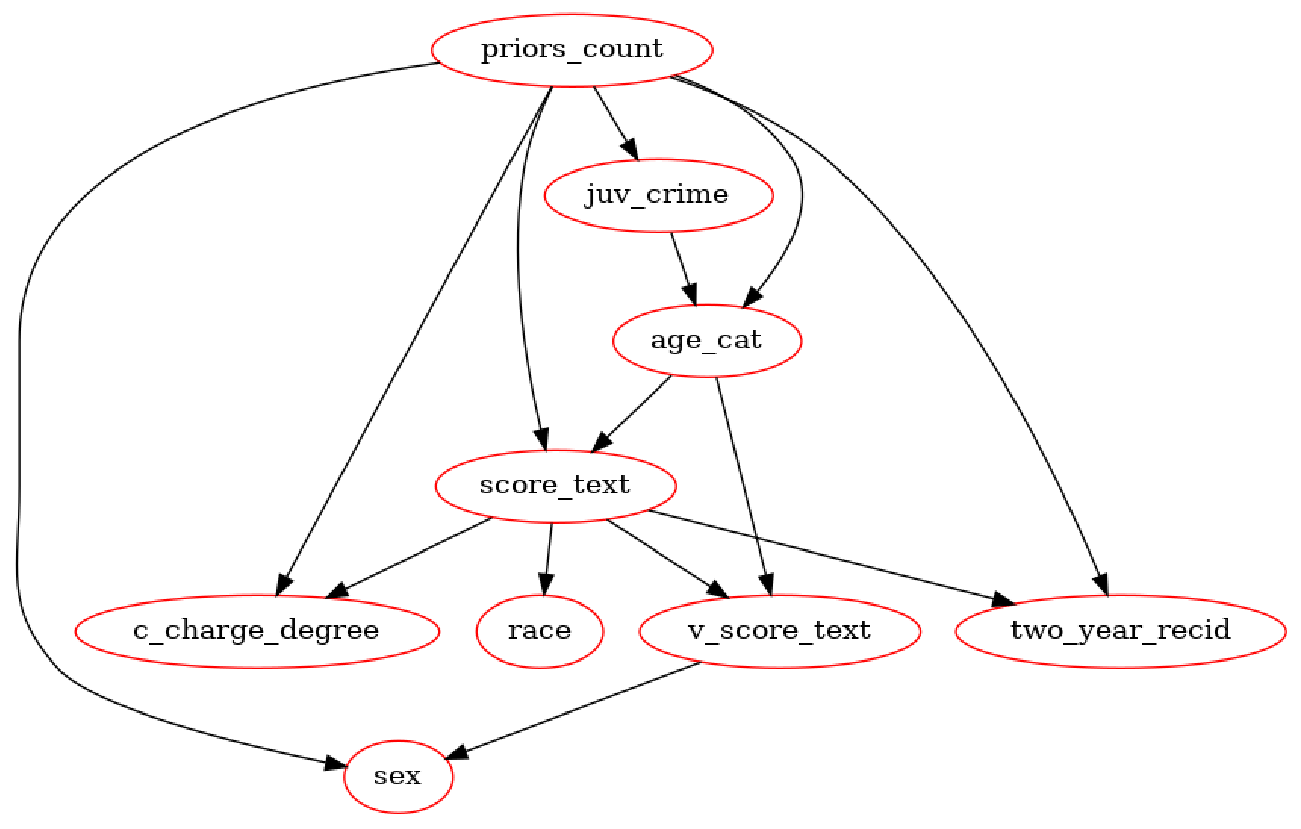

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(35, 15))
model.plot()
plt.savefig('compas.pdf')

In [48]:
import networkx
from pomegranate.utils import plot_networkx
a = networkx.DiGraph()
b = tuple(( 0,1,2,3,4,5,6,7))
c= tuple((8,))
#d=tuple((0,))
a.add_edge(b,c)
a.add_edge(b,b)
model = BayesianNetwork.from_samples(X, algorithm='exact',constraint_graph=a,state_names=labels)
print(model.structure)

((4, 7), (3, 4), (6,), (4,), (), (4, 6), (1, 4), (1, 6), (4, 6))


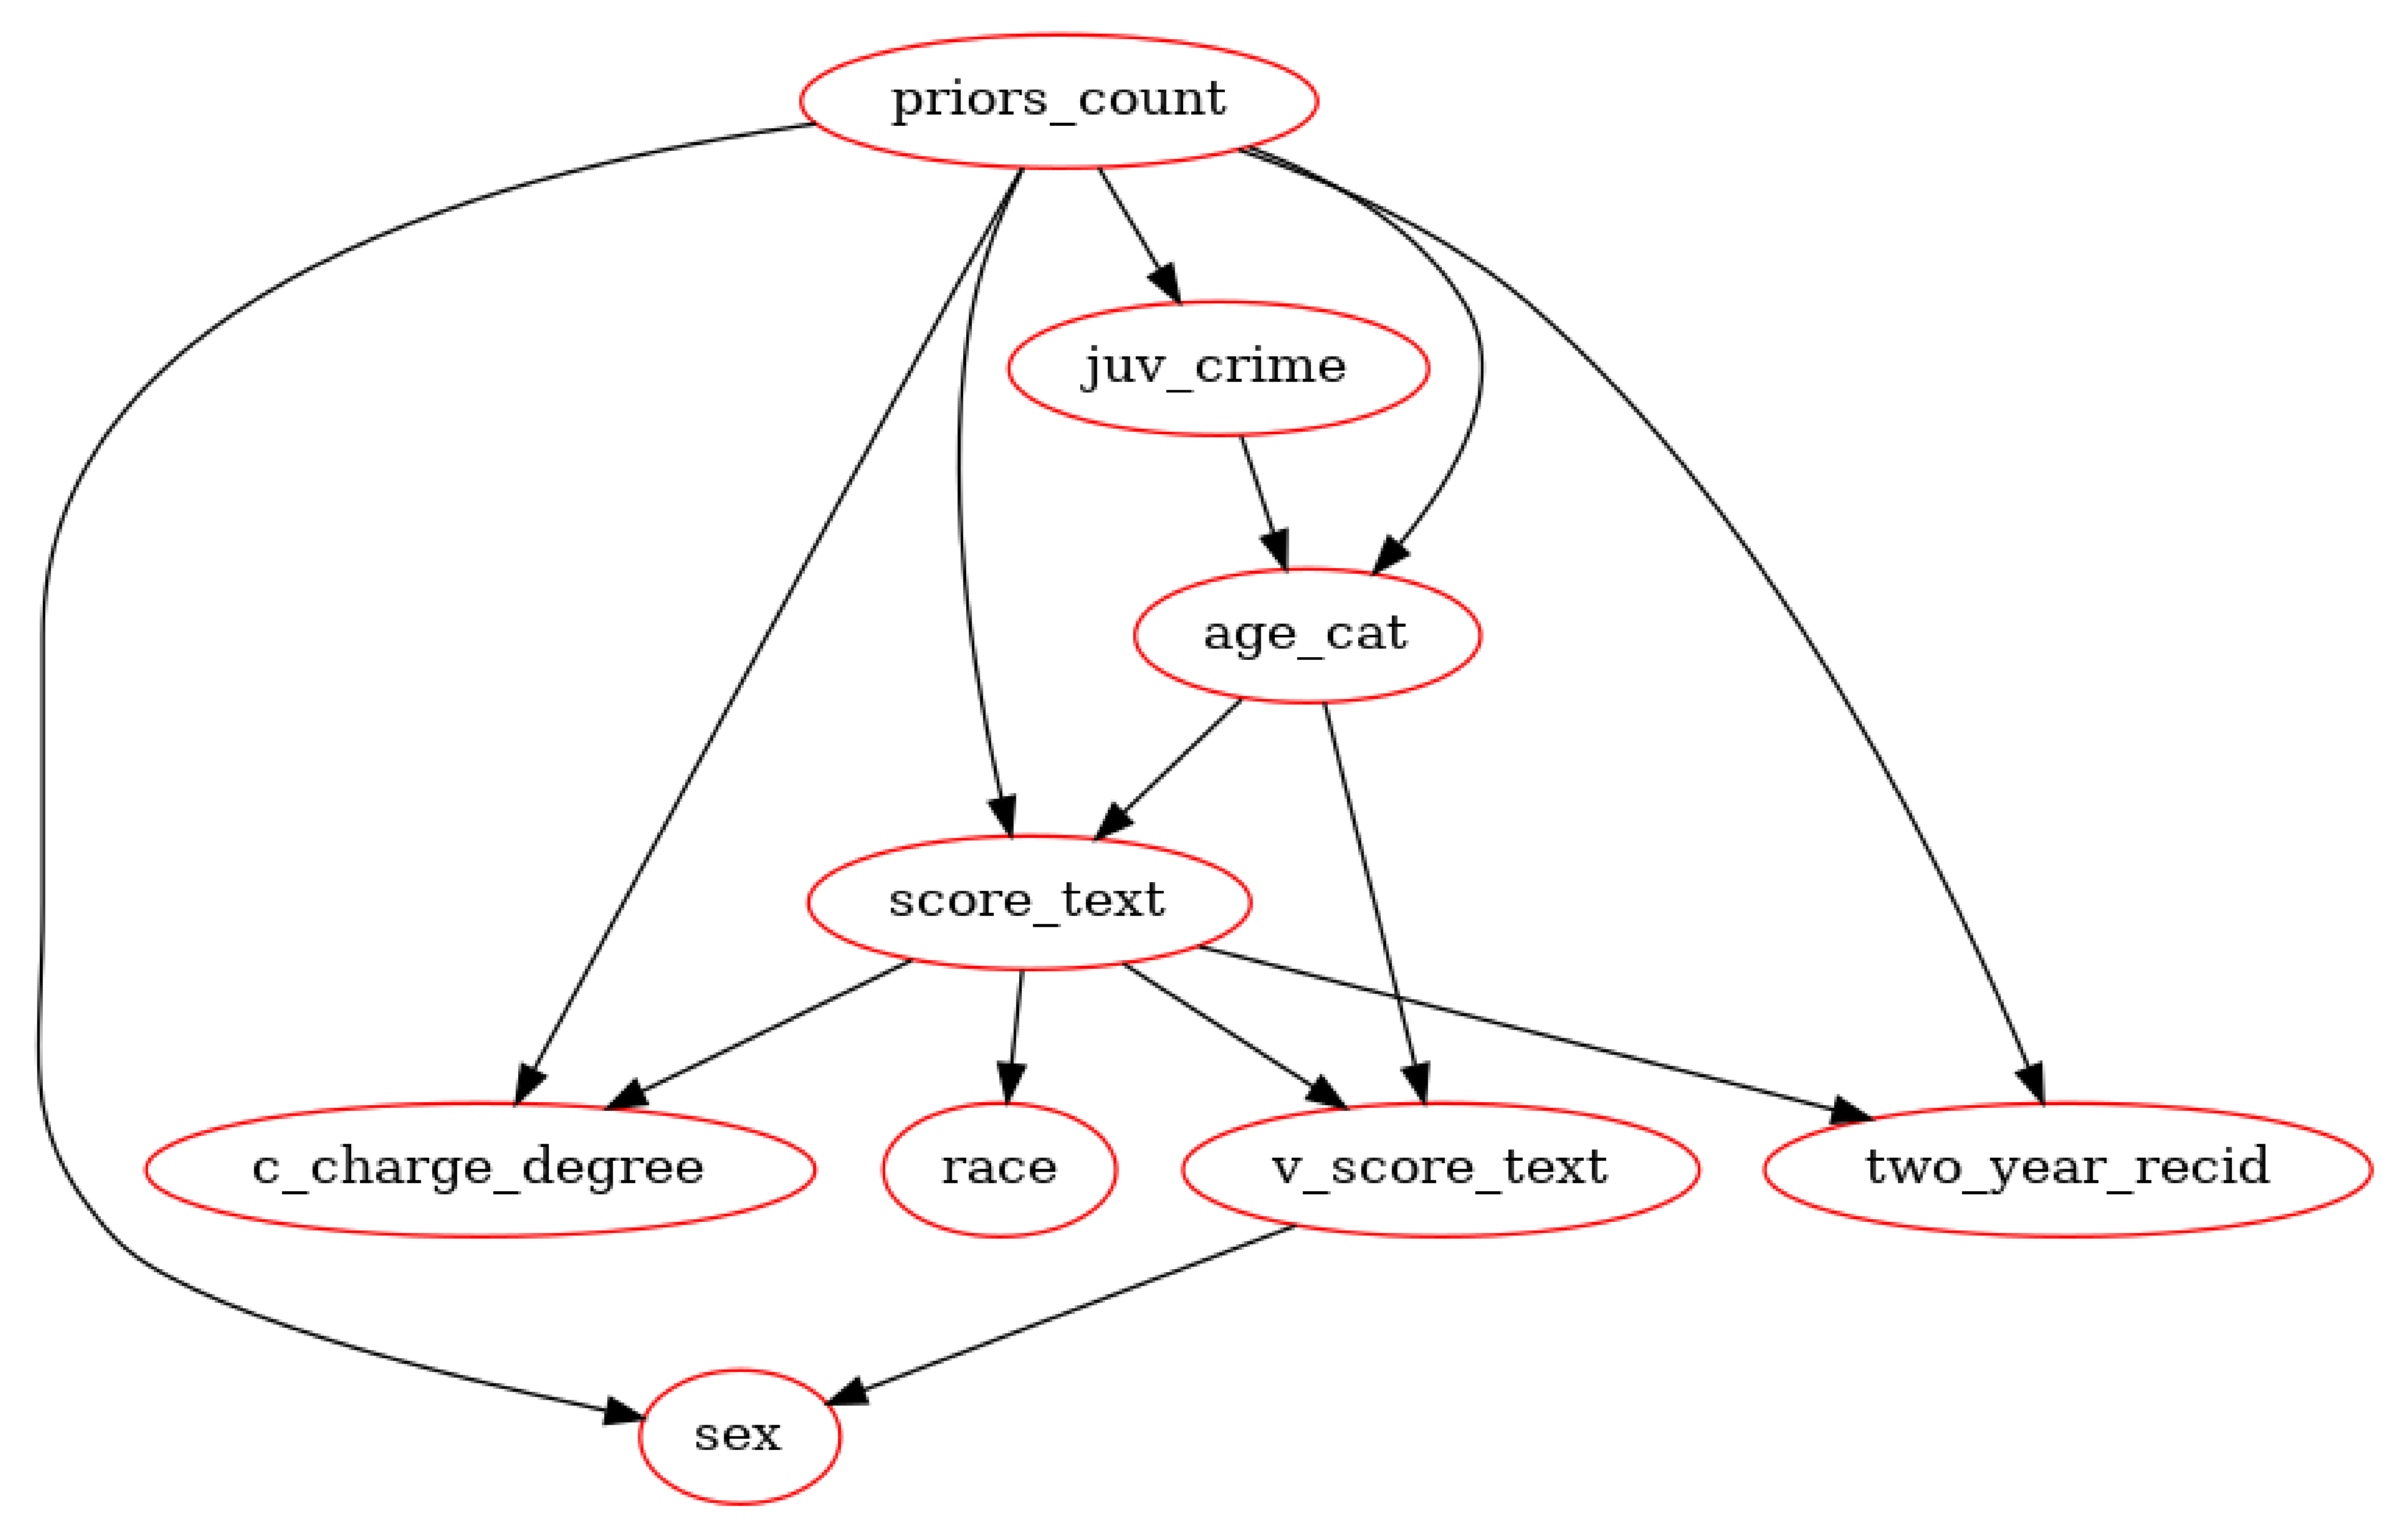

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10),dpi=400)
model.plot()
plt.savefig('COMPAS.BN.pdf',bbox_inches='tight')

## 3.2 COMPAS viol. recid.

In [50]:
df1_bn=df1.drop(columns=['id','name', 'first', 'last', 'compas_screening_date','dob','age','days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'is_recid', 'r_case_number','c_charge_desc','r_charge_desc',
       'r_days_from_arrest', 'r_offense_date',
        'r_jail_in', 'r_jail_out', 'violent_recid','r_charge_degree',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment','v_type_of_assessment','v_screening_date', 
                     'in_custody', 'out_custody','start', 'end', 'screening_date','event','v_decile_score','decile_score.1','priors_count.1','decile_score'])

In [51]:
jsum=df1_bn['juv_fel_count']+df1_bn['juv_misd_count']+df1_bn['juv_other_count']
df1_bn['juv_fel_count']=jsum
df1_bn=df1_bn.rename(columns={'juv_fel_count':'juv_crime'})
df1_bn=df1_bn.drop(columns=['juv_misd_count','juv_other_count'])

In [52]:
X1=df1_bn.values

In [53]:
for i in range(len(list(df1_bn.keys()))):
    print(i,list(df1_bn.keys())[i])

0 sex
1 age_cat
2 race
3 juv_crime
4 priors_count
5 c_charge_degree
6 score_text
7 v_score_text
8 two_year_recid


In [54]:
#X1[:,5]=numpy.array([0 if v<1 else 1 if v>=1 and v<=5 else 2 for v in X1[:,5]])
X1[:,4]=numpy.array([0 if v==0 else 1 if v>0 and v<=5 else 2 for v in X1[:,4]])
X1[:,3]=numpy.array([0 if v==0 else 1 for v in X1[:,3]])
#X1[:,2]=numpy.array(['Minority' if v!='Caucasian' else v for v in X1[:,2]])

In [55]:
labels1=list(df1_bn.keys())
#labels1[5]='Current_charge_degree'
#labels1[6]='score'
#labels1[7]='violence_score'
labels1

['sex',
 'age_cat',
 'race',
 'juv_crime',
 'priors_count',
 'c_charge_degree',
 'score_text',
 'v_score_text',
 'two_year_recid']

((4, 5), (4, 6), (6,), (1, 4), (6,), (1, 4), (), (1, 6), (4, 6))


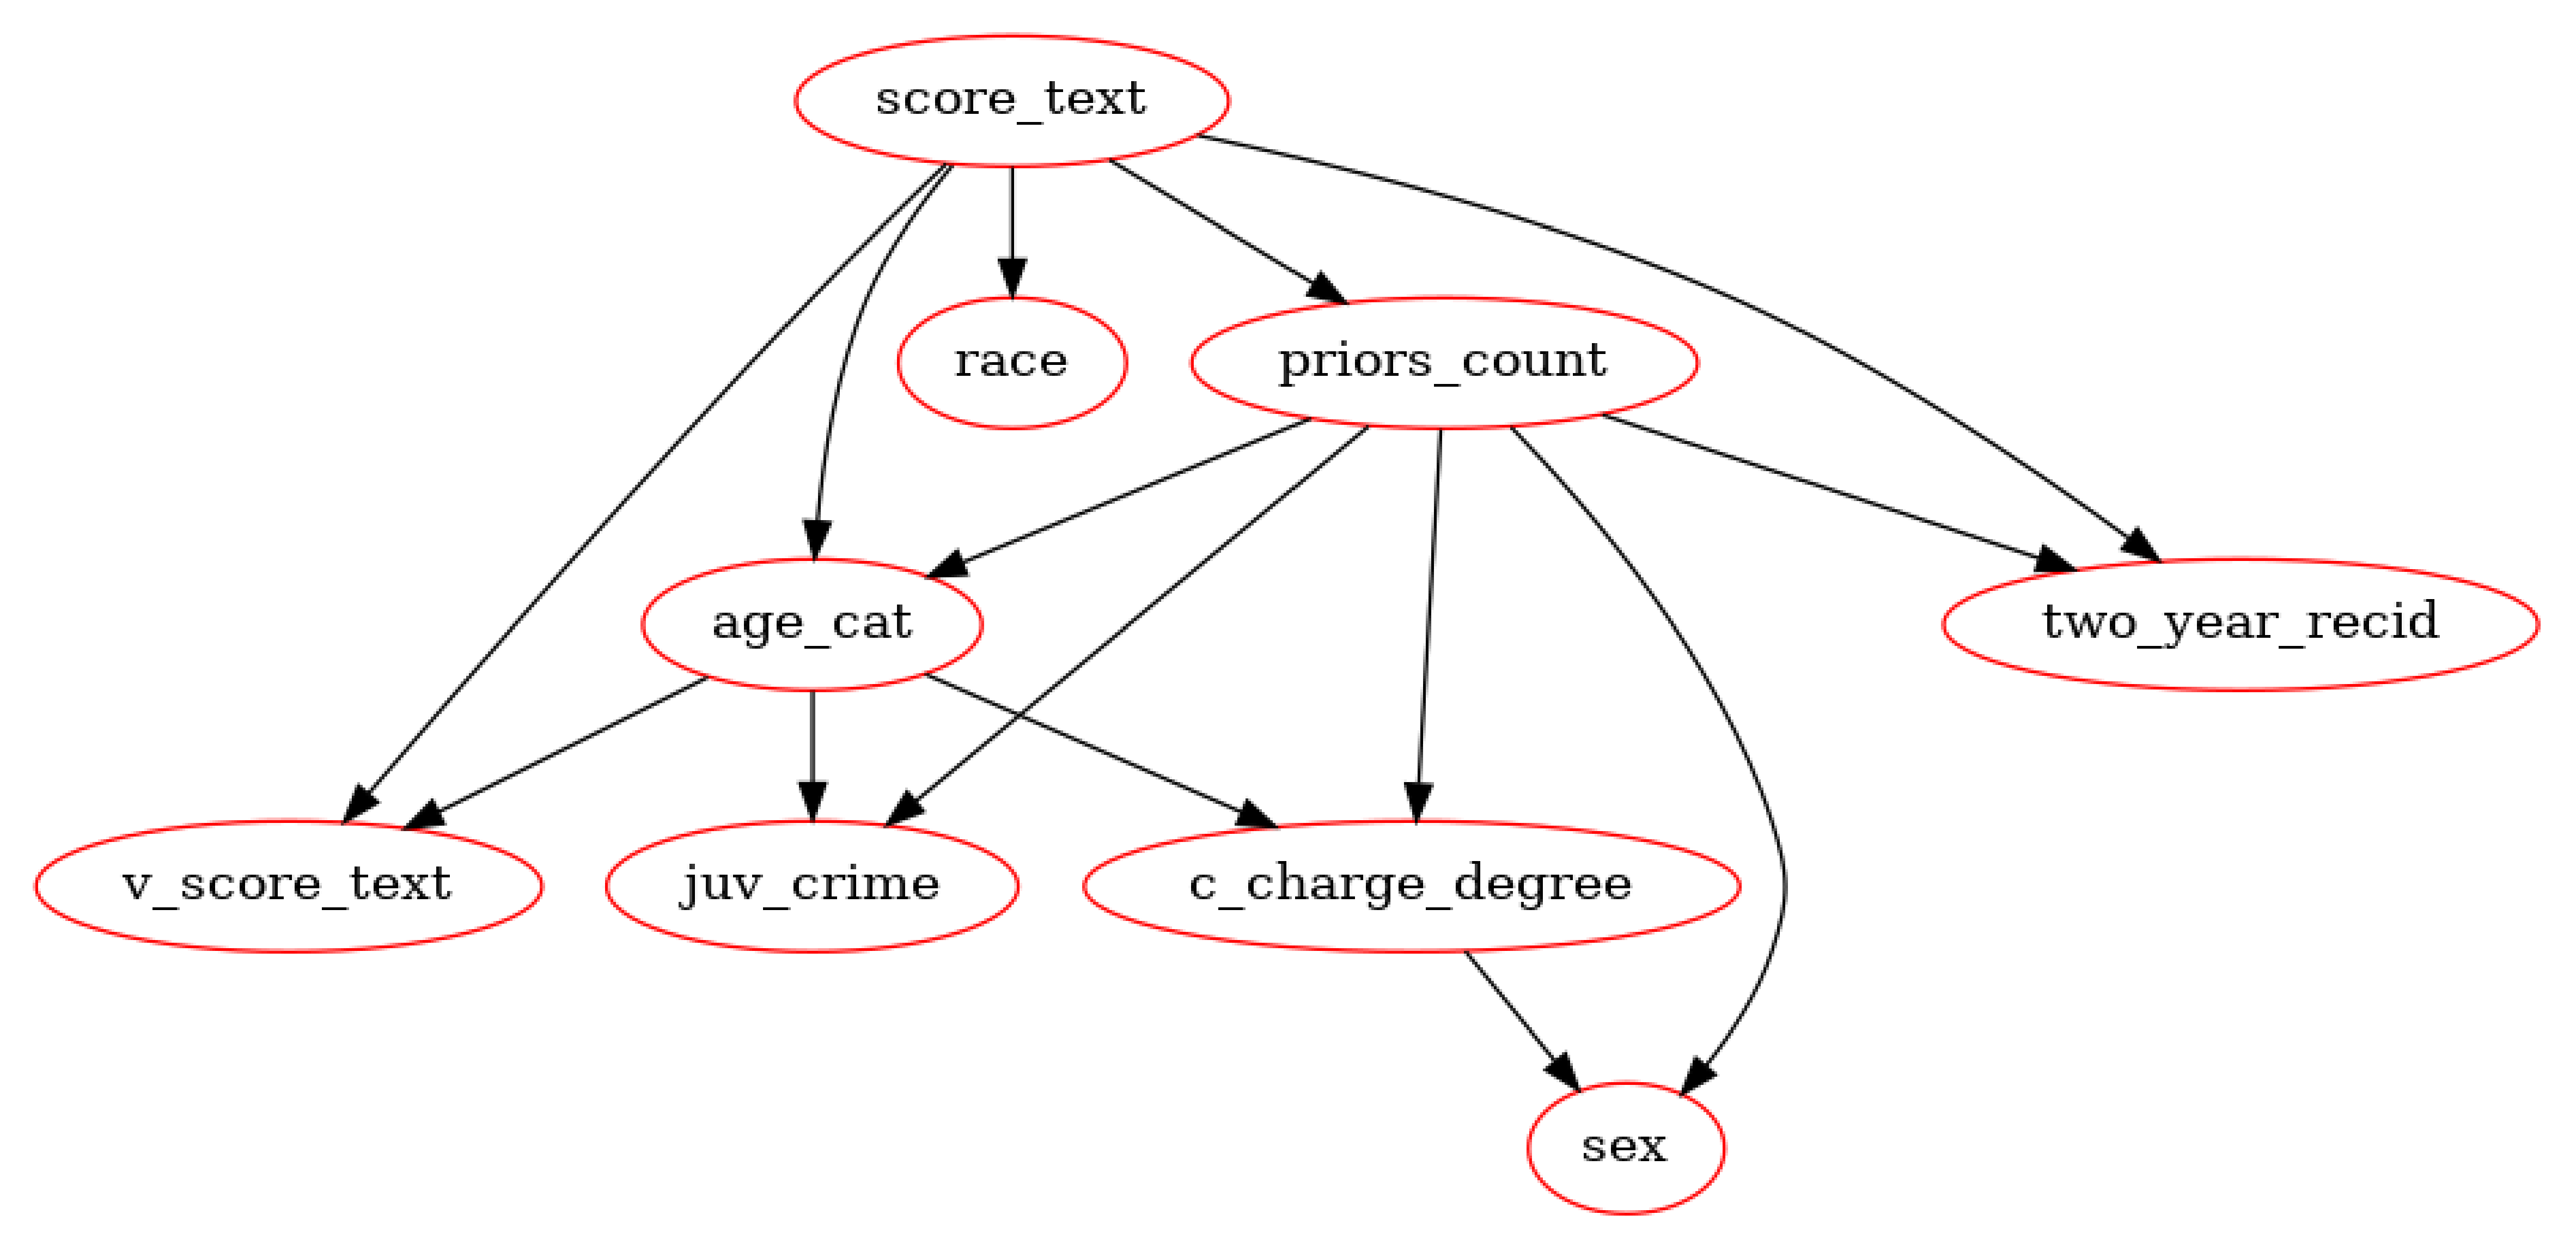

In [56]:
a = networkx.DiGraph()
b = tuple(( 0,1,2,3,4,5,6,7))
c= tuple((8,))
#d=tuple((0,))
a.add_edge(b,c)
a.add_edge(b,b)
model = BayesianNetwork.from_samples(X1, algorithm='exact',constraint_graph=a,state_names=labels1)
print(model.structure)
plt.figure(figsize=(15, 10),dpi=400)
model.plot()
plt.savefig('COMPAS.viol.BN.pdf',bbox_inches='tight')